# RAG Chat Bot for Hybrid Search

This is the accompanying notebook for the Oct 19 (2023) RAG for Hybrid Search meetup.

---

Quick notes:
- You will need an OpenAI API Key
- You will need a Pinecone account
- This notebook is meant to run on a Macbook Pro (m2)

---

Install `unstructured[pdf]` and [run the docker container](https://unstructured-io.github.io/unstructured/api.html#using-docker-images).

You'll also need to `brew install` both `tesseract` and `poppler`, since they're dependencies of the `ocr_only` strategy we'll be employing. 

[Read more about how unstructured partitions PDFs & why the fact that our PDFs have columns determined our use of the `ocr_only` strategy. 
](https://unstructured-io.github.io/unstructured/bricks/partition.html#partition-pdf)

Make sure you have [docker](https://docs.docker.com/engine/install/) and [homebrew](https://brew.sh/) installed for the above steps. 

In [2]:
!docker pull quay.io/unstructured-io/unstructured-api:latest
!docker run -p 8000:8000 -d --rm --name unstructured-api quay.io/unstructured-io/unstructured-api:latest --port 8000 --host 0.0.0.0

latest: Pulling from unstructured-io/unstructured-api

b5160cc0: Already exists 
320482ea: Already exists 
a22943c4: Already exists 
70fd9ee4: Already exists 
77a9633b: Already exists 
bda4f174: Already exists 
b700ef54: Already exists 
576952d1: Already exists 
75661cd1: Pulling fs layer 
6aee830d: Pulling fs layer 
6db040de: Pulling fs layer 
028e2e92: Pulling fs layer 
d2f74c31: Pulling fs layer 
eca5bdc2: Pulling fs layer 
1b124eb0: Pulling fs layer 
Digest: sha256:af36213047c8b93ea7a5704e73a030ebcd0d3fdd1b7e667d02bd38960d0706d8[7ADownloading  63.99MB/394.3MBDownloading  50.71MB/70.4MBDownloading  64.71MB/70.4MB
Status: Downloaded newer image for quay.io/unstructured-io/unstructured-api:latest
quay.io/unstructured-io/unstructured-api:latest

What's Next?
  View a summary of image vulnerabilities and recommendations → docker scout quickview quay.io/unstructured-io/unstructured-api:latest
docker: Error response from daemon: Conflict. The container name "/unstructured-api" is already 

In [3]:
!brew install tesseract
!brew install poppler
!pip3 install sentence-transformers
!pip3 install pinecone-client
!pip3 install pinecone-text
!pip3 install unstructured 

==> Downloading https://formulae.brew.sh/api/formula.jws.json
######################################################################### 100.0%
==> Downloading https://formulae.brew.sh/api/cask.jws.json

To reinstall 5.3.3, run:
  brew reinstall tesseract
To reinstall 23.10.0, run:
  brew reinstall poppler

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: pip3 install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: pip3 install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: pip3 install --upgrade pip


Imports

In [195]:
import pinecone
import os
import re
from uuid import uuid4
from typing import IO, Any, Dict, List
from copy import deepcopy

from unstructured.partition.pdf import partition_pdf
from unstructured.documents import elements
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
import pinecone
import openai
from pinecone.core.client.model.query_response import QueryResponse



from pinecone_text.sparse import BM25Encoder

# TODO: order these correctly

Set up the environment variables we'll need. We recommend using `dotenv`. It's a super simple way to keep your variables safe, but accessible. Simply create a `.env` file with your secrets in it, and use the Python `dotenv` and `os` libraries to load them.

In [64]:
%load_ext dotenv
from dotenv import load_dotenv
import os

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [177]:
# Make sure dotenv is in our kernel environment & working

load_dotenv()

True

In [66]:
pinecone_api_key = os.getenv('PINECONE_API_KEY')  # You can get your Pinecone api key and env (e.g. "us-east-1") at app.pinecone.io
pinecone_env = os.getenv('PINECONE_ENV')
openai_api_key = os.getenv('OPENAI_API_KEY')


In [178]:
# Let's make sure our dotenv secrets loaded correctly

assert len(pinecone_api_key) > 0
assert len(pinecone_env) > 0
assert len(openai_api_key) > 0

# Download some articles we're interested in learning more about. 

Remember, hybrid search is best for knowledge that contains a lot of unique keywords that you'd like to search for, along with concepts you'd like clarity on, etc. Data that works best for this type of thing include medical data, most types of research data, data with lots of entities in it, etc.

We'll be using Arxiv.org articles about different vector search algorithms for this demo. They've got lots of jargon and concepts that'll work great for hybrid search!

In [7]:
freshdisk = os.path.join("/Users/audrey.lorberfeld/Downloads/freshdiskann_paper.pdf")
hnsw = os.path.join("/Users/audrey.lorberfeld/Downloads/hnsw_paper.pdf")
ivfpq = os.path.join("/Users/audrey.lorberfeld/Downloads/ivfpq_paper.pdf")

# Partitioning & Cleaning our PDFs

This step is optional. Partitioning simply uses ML to break a document up into pages, paragraphs, the title, etc. It's a nice-to-have that allows you to exclude certain elements you might not want to index, such as an article's bibliography (although we'll keep that since it could be useful information). 

If you want to skip this step, you can just read the PDFs into text or json, etc. and make your chunks straight from that object(s). 

Note: this notebook assumes you have partitioned your PDF. If you want to run this notebook from start to finish as-is, you'll need to run this step.

In [8]:
# Let's partition all of our PDFs and store their partitions in a dictionary for easy retrieval & inspection later

# Note: This takes ~2 mins to run

partitioned_files = {
    "freshdisk": partition_pdf(freshdisk, url=None, strategy = 'ocr_only'),
    "hnsw": partition_pdf(hnsw, url=None, strategy = 'ocr_only'),
    "ivfpq": partition_pdf(ivfpq, url=None, strategy = 'ocr_only'),            
}   


In [9]:
# Let's make an archived copy of partitioned_files dict so if we mess it up while cleaning, we don't have to re-ocr our PDFs:

partitioned_files_copy = deepcopy(partitioned_files)

In [10]:
partitioned_files.get('freshdisk')


You can see in the preview above that each of our PDFs now has elements classifying different parts of the text, such as `Text`, `Title`, and `EmailAddress`.

Data cleaning matters a lot when it comes to hybrid search, because for the keyword-search part we care about each individual token (word).

Let's filter out all of the email addresses to start with, since we don't need those for any reason.

In [179]:
def remove_unwanted_categories(elements: Dict[str, List[elements]], unwanted_cat: str) -> None: 
    """
    Remove partitions containing an unwanted category.
    
    :parameter elements: Partitioned pieces of our documents.
    :parameter unwanted_cat: The name of the category we'd like filtered out.
    """
    for key, value in elements.items():
        elements[key] = [i for i in value if not i.category == unwanted_cat]
        

In [12]:
# Remove unwanted EmailAddress category from dictionary of partitioned PDFs

remove_unwanted_categories(partitioned_files, 'EmailAddress')

No more `EmailAddress` elements!:

In [13]:
partitioned_files.get('freshdisk')  # todo: make this partitioned_files for publication

To actually see what our elements are, we can call the `.text` attribute of each object:

In [14]:
# Text preview of what's actually in one of our dictionary items:

[i.text for i in partitioned_files.get('freshdisk')]

['arXiv:2105.09613v1 [cs.IR] 20 May 2021',
 'FreshDiskANN: A Fast and Accurate Graph-Based ANN Index for Streaming Similarity Search',
 'Aditi Singh',
 't',
 '',
 'Microsoft Research India',
 'Abstract',
 'Approximate nearest neighbor search (ANNS) is a funda- mental building block in information retrieval with graph- based indices being the current state-of-the-art [7] and widely used in the industry. Recent advances [51] in graph-based in- dices have made it possible to index and search billion-point datasets with high recall and millisecond-level latency on a single commodity machine with an SSD.',
 'However, existing graph algorithms for ANNS support only static indices that cannot reflect real-time changes to the corpus required by many key real-world scenarios (e.g. index of sentences in documents, email or a news index). To overcome this drawback, the current industry practice for manifesting updates into such indices is to periodically re-build these indices, which can be prohi

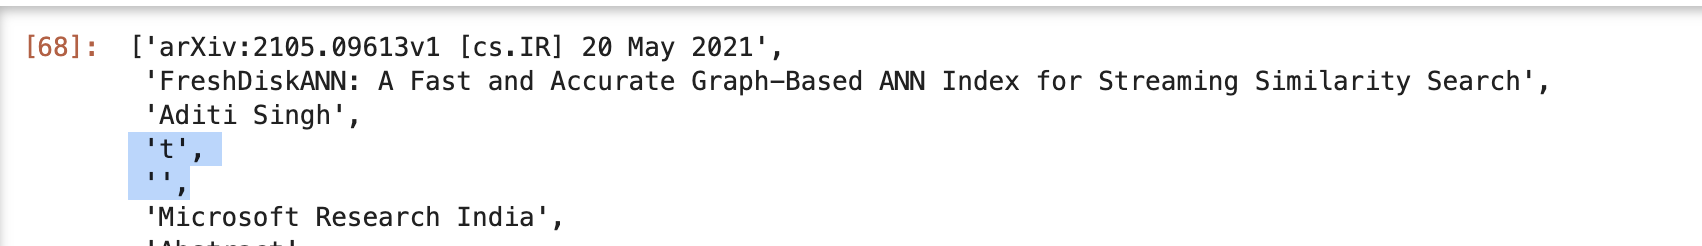

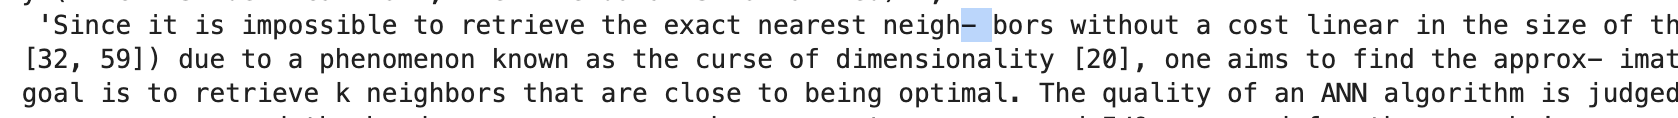

You can see there are weird things like blank spaces, single letters, etc. as their own partitions. We don't want these either, so let's get rid of them. 

You can also see where some page breaks were that spanned single words -- these are identifiable by a word ending with a `- `. For these, we want to get rid of the `- ` and squish the word back together, so it makes sense.

(You can also see that not all of the email addresses were caught by Unstructured's ML. It's too cumbersome to go through each doc and weed those out by hand, so we'll just have to leave them for now)

In [15]:
# Remove empty spaces & single-letter/-digit partitions:

def remove_space_and_single_partitions(elements: Dict[str, List[elements]]) -> None: 
    """
    Remove empty partitions & partitions with lengths of 1.
    
    :parameter elements: Partitioned pieces of our documents.
    """
    for key, value in elements.items():
        elements[key] = [i for i in value if len(i.text.strip()) > 1 ]

In [16]:
remove_space_and_single_partitions(partitioned_files)

No more single-character partitions or partitions with only whitespace, perfect!

In [17]:
[i.text for i in partitioned_files.get('freshdisk')]

['arXiv:2105.09613v1 [cs.IR] 20 May 2021',
 'FreshDiskANN: A Fast and Accurate Graph-Based ANN Index for Streaming Similarity Search',
 'Aditi Singh',
 'Microsoft Research India',
 'Abstract',
 'Approximate nearest neighbor search (ANNS) is a funda- mental building block in information retrieval with graph- based indices being the current state-of-the-art [7] and widely used in the industry. Recent advances [51] in graph-based in- dices have made it possible to index and search billion-point datasets with high recall and millisecond-level latency on a single commodity machine with an SSD.',
 'However, existing graph algorithms for ANNS support only static indices that cannot reflect real-time changes to the corpus required by many key real-world scenarios (e.g. index of sentences in documents, email or a news index). To overcome this drawback, the current industry practice for manifesting updates into such indices is to periodically re-build these indices, which can be prohibitively ex

Let's now get rid of those strange words that have been split across page breaks (e.g. `funda- mental`):

In [18]:
# Note: this function transforms our elemenets into their text representations

def rejoin_split_words(elements: Dict[str, List[elements]]) -> None: 
    """
    Rejoing words that are split over pagebreaks.
    
    :parameter elements: Partitioned pieces of our documents.
    """
    for key, value in elements.items():
        elements[key] = [i.text.replace('- ', '') for i in value if '- ' in i.text]



In [19]:
rejoin_split_words(partitioned_files)

In [20]:
partitioned_files.get('freshdisk')

['Approximate nearest neighbor search (ANNS) is a fundamental building block in information retrieval with graphbased indices being the current state-of-the-art [7] and widely used in the industry. Recent advances [51] in graph-based indices have made it possible to index and search billion-point datasets with high recall and millisecond-level latency on a single commodity machine with an SSD.',
 'In this paper, we present the first graph-based ANNS index that reflects corpus updates into the index in real-time without compromising on search performance. Using update tules for this index, we design FreshDiskANN, a system that can index over a billion points on a workstation with an SSD and limited memory, and support thousands of concurrent real-time inserts, deletes and searches per second each, while retaining > 95% 5-recall@5. This represents a 5-10x reduction in the cost of maintaining freshness in indices when compared to existing methods.',
 'In the Nearest Neighbor Search proble

You can see now that we've sewn those split words back together:

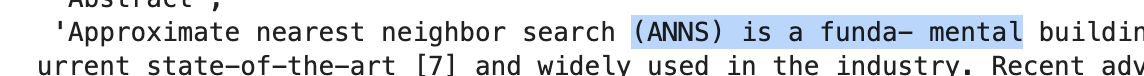

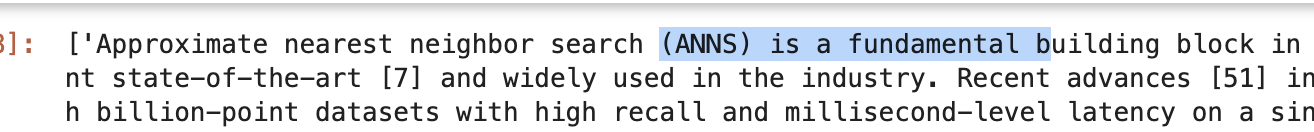

The last cleaning step we'll want to take is removing the inline citations, e.g. `[6, 9, 11, 16, 32, 35, 38, 43, 59]` and `[12]`.

In [21]:
def remove_inline_citation_numbers(elements: Dict[str, List[elements]]) -> None: 
    """
    Remove inline citation numbers from partitions.
    
    :parameter elements: Partitioned pieces of our documents.
    """
    for key, value in elements.items():
        pattern = re.compile(r'\[\s*(\d+\s*,\s*)*\d+\s*\]')
        elements[key] = [pattern.sub('', i) for i in value]



In [22]:
remove_inline_citation_numbers(partitioned_files)

We've still got some weird numbers in there, but it's pretty good!

In [23]:
partitioned_files.get('freshdisk')

['Approximate nearest neighbor search (ANNS) is a fundamental building block in information retrieval with graphbased indices being the current state-of-the-art  and widely used in the industry. Recent advances  in graph-based indices have made it possible to index and search billion-point datasets with high recall and millisecond-level latency on a single commodity machine with an SSD.',
 'In this paper, we present the first graph-based ANNS index that reflects corpus updates into the index in real-time without compromising on search performance. Using update tules for this index, we design FreshDiskANN, a system that can index over a billion points on a workstation with an SSD and limited memory, and support thousands of concurrent real-time inserts, deletes and searches per second each, while retaining > 95% 5-recall@5. This represents a 5-10x reduction in the cost of maintaining freshness in indices when compared to existing methods.',
 'In the Nearest Neighbor Search problem, we a

Now that we've cleaned our data, we can zip all the partitions (per PDF) back together so we're starting our chunking from a single, coherent text object.

In [24]:
# Sew our partitions back together, per PDF:

def stitch_partitions_back_together(elements: Dict[str, List[elements]]) -> None: 
    """
    Stitch partitions back into single string object.
    
    :parameter elements:  Partitioned pieces of our documents.
    """
    for key, value in elements.items():
        elements[key] = ' '.join(value)

In [25]:
stitch_partitions_back_together(partitioned_files)

Good to go! All of our PDFs are now cleaned and single globs of text data

In [26]:
partitioned_files

{'freshdisk': 'Approximate nearest neighbor search (ANNS) is a fundamental building block in information retrieval with graphbased indices being the current state-of-the-art  and widely used in the industry. Recent advances  in graph-based indices have made it possible to index and search billion-point datasets with high recall and millisecond-level latency on a single commodity machine with an SSD. In this paper, we present the first graph-based ANNS index that reflects corpus updates into the index in real-time without compromising on search performance. Using update tules for this index, we design FreshDiskANN, a system that can index over a billion points on a workstation with an SSD and limited memory, and support thousands of concurrent real-time inserts, deletes and searches per second each, while retaining > 95% 5-recall@5. This represents a 5-10x reduction in the cost of maintaining freshness in indices when compared to existing methods. In the Nearest Neighbor Search problem,

In [27]:
# Let's save our cleaned files to a new variable that makes more sense w/the current state 

cleaned_files = partitioned_files

# Chunking our PDF content

Chunking is integral to achieving great relevance with vector search, whether that's sparse vector search, dense vector search, or hybrid vector search.

From our [chunking strategy post](https://www.pinecone.io/learn/chunking-strategies/):

> The main reason for chunking is to ensure we’re embedding a piece of content with as little noise as possible that is still semantically relevant . . . For example, in semantic search, we index a corpus of documents, with each document containing valuable information on a specific topic. By applying an effective chunking strategy, we can ensure our search results accurately capture the essence of the user’s query. If our chunks are too small or too large, it may lead to imprecise search results or missed opportunities to surface relevant content. As a rule of thumb, if the chunk of text makes sense without the surrounding context to a human, it will make sense to the language model as well. Therefore, finding the optimal chunk size for the documents in the corpus is crucial to ensuring that the search results are accurate and relevant.

We need to chunk our PDFs' (text) data into sizable chunks that are semantically coherent and dense with contextual information. 

We'll use LangChain's `RecusiveCharacterTextSplitter` since it's a super easy utility that makes chunking quick and customizable. You should experiment with different chunk sizes and overlap values to see how the resulting chunks differ. You want each chunk to make a reasonable amount of sense as a stand-alone data object. After some experimentation on our end, we will choose a `chunk_size` of `512` and a `chunk_overlap` of `35` (characters).

In [28]:
def generate_chunks(doc: str, chunk_size: int = 512, chunk_overlap: int = 35) -> :
    """
    Generate chunks of a certain size and token overlap. 

    :param doc: Document we want to turn into chunks.
    :param chunk_size: Desired size of our chunks, in tokens (words).
    :param chunk_overlap: Desired # of tokens (words) that will overlap across chunks.

    :return: TODO
    """
    splitter = RecursiveCharacterTextSplitter(
        chunk_size = chunk_size,
        chunk_overlap = chunk_overlap
    )

    return splitter.create_documents([doc])



In [29]:
def chunk_documents(docs: Dict[str, List[elements]],  chunk_size: int = 512, chunk_overlap: int = 35) -> None: 
    """
    Iterate over documents and chunk each one.
    
    :parameter docs: The documents we want to chunk.
    :param chunk_size: Desired size of our chunks, in tokens (words).
    :param chunk_overlap: Desired # of tokens (words) that will overlap across chunks.
    """
    for key, value in docs.items():
        chunks = generate_chunks(value)
        docs[key] = [c.page_content for c in chunks]  # Grab the text representation of the chunks via the `page_content` attribute


In [30]:
chunk_documents(cleaned_files)

Check out our chunks!

In [31]:
chunked_files = cleaned_files

In [32]:
chunked_files

{'freshdisk': ['Approximate nearest neighbor search (ANNS) is a fundamental building block in information retrieval with graphbased indices being the current state-of-the-art  and widely used in the industry. Recent advances  in graph-based indices have made it possible to index and search billion-point datasets with high recall and millisecond-level latency on a single commodity machine with an SSD. In this paper, we present the first graph-based ANNS index that reflects corpus updates into the index in real-time without',
  'the index in real-time without compromising on search performance. Using update tules for this index, we design FreshDiskANN, a system that can index over a billion points on a workstation with an SSD and limited memory, and support thousands of concurrent real-time inserts, deletes and searches per second each, while retaining > 95% 5-recall@5. This represents a 5-10x reduction in the cost of maintaining freshness in indices when compared to existing methods. In

# Create Dense Embeddings of our Chunks

Hybrid search needs both dense embeddings and sparse embeddings of the same content in order to work. Let's start with dense embeddings.

We'll use the `'all-MiniLM-L12-v2'` [model](https://huggingface.co/sentence-transformers/all-MiniLM-L12-v2) hosted by HuggingFace to create our dense embeddings. It's currently high on their [MTEB (Massive Text Embedding Benchmark) Leaderboard](https://huggingface.co/spaces/mteb/leaderboard) (Reranking section), so it's a pretty safe bet. This will output dense vectors of 384 dimensions.

Note: if you're playing around with this notebook, make sure to save your chunks and embeddings (both sparse and dense) in `pkl` [files](https://stackoverflow.com/questions/11218477/how-can-i-use-pickle-to-save-a-dict-or-any-other-python-object), so that you don't have to wait for the embeddings to generate again if you want to rerun any steps in this notebook.

We'll have to create a dense embedding of each of our PDFs' chunks:

In [180]:
def produce_embeddings(chunks: List[str]) -> List[str]:
    """
    Produce dense embeddings for each chunk.

    :param chunks: The chunks we want to create dense embeddings of.

    :return: Dense embeddings produced by our SentenceTransformer model `all-MiniLM-L12-v2`.
    """
    model = SentenceTransformer('all-MiniLM-L12-v2')
    embeddings = []
    for c in chunks:
        embedding = model.encode(c)
        embeddings.append(embedding)
    return embeddings
    

In [34]:
freshdisk_dembeddings = produce_embeddings(chunked_files.get('freshdisk'))

In [35]:
hnsw_dembeddings = produce_embeddings(chunked_files.get('hnsw'))

In [36]:
ivfpq_dembeddings = produce_embeddings(chunked_files.get('ivfpq'))

In [37]:
# We can confirm the shape of each our dense embeddings is 384:

# Make binary lists to keep track of any shapes that are *not* 384
freshdisk_assertion = [0 for i in freshdisk_dembeddings if i.shape == 384]
hnsw_assertion = [0 for i in hnsw_dembeddings if i.shape == 384]
ivfpq_assertion = [0 for i in ivfpq_dembeddings if i.shape == 384]

# Sum up our lists. If there are any embeddings that are not of shape 384, these sums will be > 0
assert sum(freshdisk_assertion) == 0
assert sum(hnsw_assertion) == 0
assert sum(ivfpq_assertion) == 0

# Create Sparse Embeddings of our Chunks

Now we can create our sparse embeddings. We will use the BM25 algorithm to create our sparse embeddings. The resulting vector will represent an inverted index of the tokens in our chunks, constrained by things like chunk length. 

Pinecone has an awesome [text library](https://github.com/pinecone-io/pinecone-text) that makes generating these vectors super easy. We also have [a great notebook](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/search/semantic-search/sparse/bm25/bm25-vector-generation.ipynb) all about BM25 encodings.

Since we're using a ML-implemented version of BM25, we need to "fit" the model to our corpus. To do this, we'll combine all 3 of our PDFs together, so that the BM25 model can compute all the token frequencies etc correctly. We'll then encode each of our documents with our "fitted" model.

In [40]:
# Join the content of all our PDFs together into 1 large corpus

corpus = ""

for i, v in chunked_files.items():
    corpus += ' '.join(v)

In [43]:
len(corpus  # Awesome, we've got lots o' tokens here for our BM25 model to learn :)

127590

In [44]:
# Initialize BM25 and fit the corpus
bm25 = BM25Encoder()
bm25.fit(corpus)


100%|████████████████████████████████| 127590/127590 [00:02<00:00, 57319.30it/s]


In [49]:
# Create embeddings for each chunk
freshdisk_sembeddings = [bm25.encode_documents(i) for i in chunked_files.get('freshdisk')]

In [51]:
hnsw_sembeddings = [bm25.encode_documents(i) for i in chunked_files.get('hnsw')]

In [52]:
ivfpq_sembeddings = [bm25.encode_documents(i) for i in chunked_files.get('ivfpq')]

Let's look at the sparse embeddings for one of our PDFs.

You'll see that each PDF's chunks has now transformed into a dictionary with `indices` and `values` keys. 

In [53]:
freshdisk_sembeddings

[{'indices': [270780933,
   3650065742,
   1196854555,
   553238108,
   891354358,
   3429613387,
   2087367745,
   2691201840,
   3647400625,
   2455432819,
   3850563250,
   1563317370,
   407983593,
   2307803212,
   2751533102,
   640124220,
   91759785,
   569308866,
   728487644,
   414100959,
   3452949137,
   3927490055,
   125777136,
   3935005093,
   3096200065,
   1612531086,
   385392376,
   3453722252,
   881664426,
   1691351615,
   536145832,
   3066577729,
   1564510983,
   4183835765,
   2165730276,
   2851137560,
   173740189,
   1330873646,
   4071218396,
   1651775491,
   1477105254],
  'values': [0.02293577981651376,
   0.02293577981651376,
   0.02293577981651376,
   0.04484304932735426,
   0.04484304932735426,
   0.02293577981651376,
   0.02293577981651376,
   0.02293577981651376,
   0.02293577981651376,
   0.02293577981651376,
   0.02293577981651376,
   0.04484304932735426,
   0.02293577981651376,
   0.02293577981651376,
   0.02293577981651376,
   0.0229357798165

In [54]:
# We want the # of chunks per PDF to be equal to the # of sparse embeddings we've generated. Let's check that:

assert len(freshdisk_sembeddings) == len(chunked_files.get('freshdisk'))
assert len(hnsw_sembeddings) == len(chunked_files.get('hnsw'))
assert len(ivfpq_sembeddings) == len(chunked_files.get('ivfpq'))

# Getting Our Embeddings into Pinecone

Now that we have made our sparse and dense embeddings, it's time to index them into our Pinecone index.

One thing to note is that only [p1 and s1 pods support hybrid search](https://docs.pinecone.io/docs/indexes). Since we're not concerned about high throughput for a demo, we'll go with s1, which is optimized for storage over throughput.

Hybrid search inherently also needs `"dotproduct"` as the similarity `metric`.

In [83]:
pinecone.init(
   api_key=pinecone_api_key,
   environment=pinecone_env
)
# choose a name for your index
index_name = "hybrid-search-demo-oct23"
 
# create the index
pinecone.create_index(
   name = index_name,
   dimension = 384,  # dimensionality of our vectors
   metric = "dotproduct",
   pod_type = "s1"
)

In [84]:
# Let's confirm everything looks good with our index

pinecone.describe_index('hybrid-search-demo-oct23')

IndexDescription(name='hybrid-search-demo-oct23', metric='dotproduct', replicas=1, dimension=384.0, shards=1, pods=1, pod_type='s1.x1', status={'ready': True, 'state': 'Ready'}, metadata_config=None, source_collection='')

We'll create an index object out of the index we just made. We'll make this with Pinecone's [GRPC client](https://docs.pinecone.io/docs/performance-tuning#using-the-grpc-client-to-get-higher-upsert-speeds), since it's a little faster for upserts:


In [85]:
index = pinecone.GRPCIndex("hybrid-search-demo-oct23")


We'll need to make unique IDs for all of our objects, which is easy with the `uuid` library in Python:

In [86]:
def create_ids(doc):
    """
    """
    return [str(uuid4()) for _ in range(len(doc))]

In [87]:
freshdisk_ids = create_ids(chunked_files.get('freshdisk'))
hnsw_ids = create_ids(chunked_files.get('hnsw'))
ivfpq_ids = create_ids(chunked_files.get('ivfpq'))


In [88]:
# Let's preview one of our IDs:

freshdisk_ids[0]

'99762de8-9fab-4e16-a29a-c5e7780306f6'

In [89]:
# Let's make sure we have the same # of IDs as there are chunks:

assert len(freshdisk_ids) == len(chunked_files.get('freshdisk'))
assert len(hnsw_ids) == len(chunked_files.get('hnsw'))
assert len(ivfpq_ids) == len(chunked_files.get('ivfpq'))

Now that we have our IDs, we can make our composite sparse-dense objects that we'll index into Pinecone. These will take 4 components: 
- Our IDs
- Our sparse embeddings
- Our dense embeddings
- Our chunks

We'll use the actual text content of our PDFs (stored in our chunks) as metadata. This allows the end user to see the content of what's being returned by their search instead of just the sparse/dense vectors. In order to store our chunks' textual data in digestible metadata object for Pinecone, we'll want to turn each chunk into a dict that has a `'text'` key to hold the chunk value.

In [183]:
def create_metadata_objs(doc: List[str]) -> List[dict[str]]:
    """
    Create objects to store as metadata alongside our sparse and dense vectors in our hybird Pinecone index.

    :param doc: Chunks of a document we'd like to use while creating metadata objects.

    :return: Metadata objects with a "text" key and a value that points to the text content of each chunk. 
    """
    return [{'text': d} for d in doc]

In [181]:
chunked_files.get('freshdisk')

['Approximate nearest neighbor search (ANNS) is a fundamental building block in information retrieval with graphbased indices being the current state-of-the-art  and widely used in the industry. Recent advances  in graph-based indices have made it possible to index and search billion-point datasets with high recall and millisecond-level latency on a single commodity machine with an SSD. In this paper, we present the first graph-based ANNS index that reflects corpus updates into the index in real-time without',
 'the index in real-time without compromising on search performance. Using update tules for this index, we design FreshDiskANN, a system that can index over a billion points on a workstation with an SSD and limited memory, and support thousands of concurrent real-time inserts, deletes and searches per second each, while retaining > 95% 5-recall@5. This represents a 5-10x reduction in the cost of maintaining freshness in indices when compared to existing methods. In the Nearest Ne

In [91]:
freshdisk_metadata = create_metadata_objs(chunked_files.get('freshdisk'))
hnsw_metadata = create_metadata_objs(chunked_files.get('hnsw'))
ivfpq_metadata = create_metadata_objs(chunked_files.get('ivfpq'))

In [92]:
# Preview

freshdisk_metadata[0]

{'text': 'Approximate nearest neighbor search (ANNS) is a fundamental building block in information retrieval with graphbased indices being the current state-of-the-art  and widely used in the industry. Recent advances  in graph-based indices have made it possible to index and search billion-point datasets with high recall and millisecond-level latency on a single commodity machine with an SSD. In this paper, we present the first graph-based ANNS index that reflects corpus updates into the index in real-time without'}

In [187]:
freshdisk_dembeddings

[array([-7.0558913e-02, -6.8726182e-02,  9.4481390e-03,  8.1044035e-03,
         2.0985622e-02, -8.0188019e-03, -1.4574598e-01,  1.5101799e-02,
        -2.7631976e-02, -3.0254757e-02,  6.7297101e-02, -9.6366219e-03,
         1.4358070e-02, -4.3816101e-02, -9.0569228e-02, -7.5578228e-02,
         1.9433942e-01,  7.0889011e-02,  1.5773220e-02, -6.0908675e-02,
        -3.5191420e-02,  4.3446098e-02,  3.1093468e-03, -8.9537766e-04,
         1.6257625e-02, -6.6710621e-02, -1.1374410e-03,  3.9616618e-02,
         3.1250138e-03, -8.0253892e-02, -1.6012814e-02,  3.6052994e-02,
         6.6858545e-02,  5.7796188e-02, -3.8131333e-03, -2.4853691e-02,
        -8.6132912e-03,  8.5863672e-02,  1.3249672e-02, -6.1955757e-02,
         3.0823344e-02, -1.5523951e-02,  3.7986096e-02,  9.9194959e-02,
         2.8379036e-02, -2.8950488e-02, -6.1598174e-02,  1.8831102e-02,
         1.4512485e-03, -3.6705945e-02, -2.7448593e-02,  4.7351804e-02,
         9.5178261e-03, -2.1734614e-02,  2.7048780e-02,  8.18445

In [190]:
def create_composite_objs(ids: str, sembeddings: List[Dict[str, List[Any]]], dembeddings: List[float], metadata: Dict[str, str]) -> List[Dict[str, Any]]:
    """
    Create objects for indexing into Pinecone. Each object contains a document ID (which corresponds to the chunk, not the larger document), 
    the chunk's sparse embedding, the chunk's dense embedding, and the chunk's corresponding metadata object.

    :param ids: Unique ID of a chunk we want to index.
    :param sembeddings: Sparse embedding representation of a chunk we want to index.
    :param dembeddings: Dense embedding representation of a chunk we want to index.
    :param metadata: Metadata objects with a "text" key and a value that points to the text content of each chunk. 

    :return: Composite objects in the correct format for ingest into Pinecone.
    """
    to_index = []

    for i in range(len(metadata)):
        to_index_obj = {
                'id': ids[i],
                'sparse_values': sembeddings[i],
                'values': dembeddings[i],
                'metadata': metadata[i]
            }
        to_index.append(to_index_obj)
    return to_index

In [95]:
freshdisk_com_objs = create_composite_objs(freshdisk_ids, freshdisk_sembeddings, freshdisk_dembeddings, freshdisk_metadata)
hnsw_com_objs = create_composite_objs(hnsw_ids, hnsw_sembeddings, hnsw_dembeddings, hnsw_metadata)
ivfpq_com_objs = create_composite_objs(ivfpq_ids, ivfpq_sembeddings, ivfpq_dembeddings, ivfpq_metadata)

In [96]:
freshdisk_com_objs[0]

{'id': '99762de8-9fab-4e16-a29a-c5e7780306f6',
 'sparse_values': {'indices': [270780933,
   3650065742,
   1196854555,
   553238108,
   891354358,
   3429613387,
   2087367745,
   2691201840,
   3647400625,
   2455432819,
   3850563250,
   1563317370,
   407983593,
   2307803212,
   2751533102,
   640124220,
   91759785,
   569308866,
   728487644,
   414100959,
   3452949137,
   3927490055,
   125777136,
   3935005093,
   3096200065,
   1612531086,
   385392376,
   3453722252,
   881664426,
   1691351615,
   536145832,
   3066577729,
   1564510983,
   4183835765,
   2165730276,
   2851137560,
   173740189,
   1330873646,
   4071218396,
   1651775491,
   1477105254],
  'values': [0.02293577981651376,
   0.02293577981651376,
   0.02293577981651376,
   0.04484304932735426,
   0.04484304932735426,
   0.02293577981651376,
   0.02293577981651376,
   0.02293577981651376,
   0.02293577981651376,
   0.02293577981651376,
   0.02293577981651376,
   0.04484304932735426,
   0.02293577981651376,
  

Now we can index ("upsert") our objects into our Pinecone index!

In [97]:
index.upsert(freshdisk_com_objs)
index.upsert(hnsw_com_objs)
index.upsert(ivfpq_com_objs)


upserted_count: 59

In [98]:
# Woo we have our vectors (253) in our index!

index.describe_index_stats()

{'dimension': 384,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 253}},
 'total_vector_count': 253}

# Query Our Hybrid Docs

Now that we have all of our hybrid vector objects in our Pinecone index, we can issue some queries!

Since issuing a query to a vector index requires the query to be vectorized in the same way as the objects in the index are vectorized (so they can match up in vector space), for hybrid queries we'll have to vectorize the query *twice*! Once as a sparse vector and once as a dense vector. We then send both of those vectors to Pinecone to get items back.

In [99]:
query = "What are nearest neighbors?" 


In [100]:
# Create sparse embedding from query

# Note: do *not* refit the bm25 model here. We want to keep the token frequencies etc from when we fit it to the text from our PDFs!

# You might be wondering how the model gets "refit" when the corpus changes, the answer is a little complicated, but essentially
# this is a special implementation of BM25 (which usually runs online) that has precomputed frequencies for English words, based
# off the MSMarco dataset. So, when you add new docs to the corpus, you don't have to "refit" the BM25 model, it just finds the 
# word frequencies in the MSMarco dataset.
    # - More here: https://github.com/pinecone-io/pinecone-text/blob/main/pinecone_text/sparse/bm25_encoder.py#L255

query_sembedding = bm25.encode_documents(query)

In [102]:
# Cool! We can see there are only two values in here, because BM25 automatically removed stop word like "what" and "is"

query_sembedding  

{'indices': [3650065742, 1196854555],
 'values': [0.3225806451612903, 0.3225806451612903]}

In [103]:
# Create dense embedding

query_dembedding = produce_embeddings([query])

In [104]:
query_dembedding

[array([ 3.93597633e-02, -4.73917983e-02, -4.04573157e-02, -3.46427038e-02,
        -9.91891418e-03,  9.67442244e-03, -7.91811422e-02,  5.16992770e-02,
        -1.95026528e-02, -1.82915330e-02,  4.21765037e-02, -2.76289284e-02,
         3.47405039e-02, -2.30831560e-02, -1.08419977e-01,  3.71121354e-02,
         6.21359870e-02, -2.54765302e-02, -3.14433835e-02, -5.88753410e-02,
        -7.58902356e-02,  1.44599695e-02,  2.41217576e-02,  2.67989896e-02,
         6.24472648e-02, -6.25005662e-02,  6.11939691e-02, -4.98114899e-03,
         1.92482434e-02, -1.17263142e-02, -5.68607673e-02,  7.51190707e-02,
         6.08491488e-02,  2.20751073e-02,  3.56491916e-02,  1.04025435e-02,
        -4.32658009e-03,  8.42948556e-02, -5.93700334e-02,  2.46451609e-02,
         1.37929842e-01, -4.35611010e-02,  6.47361130e-02,  4.99044433e-02,
        -6.89831451e-02, -8.31322372e-03,  3.35846506e-02, -5.25762746e-03,
        -3.74429673e-02, -1.05748311e-01, -4.40458171e-02, -4.96782213e-02,
        -5.0

Pinecone vector search has a cool user feature where you can weight the sparse vectors higher or lower (i.e. of more or less importance) than the dense vectors. This is controlled by the `alpha` parameter. An `alpha` of 0 means you're doing a totally keyword-based search (i.e. only over sparse vectors), while an `alpha` of 1 means you're doing a totally semantic search (i.e. only over dense vectors).

Let's make a function that'll let us weight our vectors by alpha.

(We'll also include `k`, which is the number of docs we want to retrieve)

In [194]:
# Integrate alpha and top-k

# TODO: figure out type annotation for double return

def weight_by_alpha(sparse_embedding: Dict[str, List[Any]], dense_embedding: List[float], alpha: float) -> Dict[str, List[Any]], List[float]:
    """
    Weight the values of our sparse and dense embeddings by the parameter alpha (0-1).

    :param sparse_embedding: Sparse embedding representation of one of our documents (or chunks).
    :param dense_embedding: Dense embedding representation of one of our documents (or chunks).
    :param alpha: Weighting parameter between 0-1 that controls the impact of sparse or dense embeddings on the retrieval and ranking
        of returned docs (chunks) in our index.

    :return: Weighted sparse and dense embeddings for one of our documents (chunks).
    """
    if alpha < 0 or alpha > 1:
        raise ValueError("Alpha must be between 0 and 1")
    hsparse = {
        'indices': sparse_embedding['indices'],
        'values':  [v * (1 - alpha) for v in sparse_embedding['values']]
    }
    hdense = [v * alpha for v in dense_embedding]
    return hsparse, hdense

SyntaxError: expected ':' (4098237725.py, line 3)

In [106]:
# Test out our function:

weight_by_alpha(query_sembedding, query_dembedding, 0.1)

({'indices': [3650065742, 1196854555],
  'values': [0.2903225806451613, 0.2903225806451613]},
 [array([ 3.9359764e-03, -4.7391797e-03, -4.0457319e-03, -3.4642704e-03,
         -9.9189149e-04,  9.6744223e-04, -7.9181148e-03,  5.1699276e-03,
         -1.9502653e-03, -1.8291533e-03,  4.2176503e-03, -2.7628930e-03,
          3.4740504e-03, -2.3083156e-03, -1.0841998e-02,  3.7112136e-03,
          6.2135989e-03, -2.5476532e-03, -3.1443385e-03, -5.8875340e-03,
         -7.5890236e-03,  1.4459969e-03,  2.4121758e-03,  2.6798991e-03,
          6.2447265e-03, -6.2500569e-03,  6.1193970e-03, -4.9811491e-04,
          1.9248243e-03, -1.1726314e-03, -5.6860768e-03,  7.5119073e-03,
          6.0849148e-03,  2.2075109e-03,  3.5649191e-03,  1.0402544e-03,
         -4.3265801e-04,  8.4294854e-03, -5.9370035e-03,  2.4645161e-03,
          1.3792984e-02, -4.3561100e-03,  6.4736116e-03,  4.9904445e-03,
         -6.8983147e-03, -8.3132240e-04,  3.3584652e-03, -5.2576273e-04,
         -3.7442967e-03, -1.05

Now let's make a function that'll query our Pinecone index while taking into account whatever `alpha` and `k` values we want to pass:

In [196]:
# Note this doesn't have any genAI in it yet


def issue_hybrid_query(sparse_embedding: Dict[str, List[Any]], dense_embedding: List[float], alpha: float, top_k: int) -> QueryResponse:
    """
    Send properly formatted hybrid search query to Pinecone index and get back `k` ranked results (ranked by dot product similarity, as 
        defined when we made our index).

    :param sparse_embedding: Sparse embedding representation of one of our documents (or chunks).
    :param dense_embedding: Dense embedding representation of one of our documents (or chunks).
    :param alpha: Weighting parameter between 0-1 that controls the impact of sparse or dense embeddings on the retrieval and ranking
        of returned docs (chunks) in our index.
    :param top_k: The number of documents (chunks) we want back from Pinecone.

    :return: QueryResponse object from Pinecone containing top-k results.
    """
    scaled_sparse, scaled_dense = weight_by_alpha(sparse_embedding, dense_embedding, alpha)

    result = index.query(
        vector=scaled_dense,
        sparse_vector=scaled_sparse,
        top_k=top_k,
        include_metadata=True
    )
    return result

Let's issue a pure semantic search:

In [108]:
# Note, for our dense embedding (`query_dembedding`), we need to grab the 1st value [0] since Pinecone expects a Numpy array when queried:

issue_hybrid_query(query_sembedding, query_dembedding[0], 0.0, 5)

{'matches': [{'id': '5856cf9d-8e3c-4707-bfea-66f290dd8576',
              'metadata': {'text': 'to the closest neighbors in a k-NN graph '
                                   'serve as a simple approximation of the '
                                   'Delaunay graph  (a graph which guranties '
                                   'that the result of a basic greedy graph '
                                   'traversal is always the nearest neighbor). '
                                   'Unfortunately, Delaunay graph cannot be '
                                   'efficiently constructed without prior '
                                   'information about the structure of a space '
                                   ', but its approximation by the nearest '
                                   'neighbors can be done by using only '
                                   'distances between the stored elements. It '
                                   'was shown that proximity graph approaches '


And now a pure keyword search. You can see how many more domain-specific words are in these results:

In [109]:
issue_hybrid_query(query_sembedding, query_dembedding[0], 1.0, 5)

{'matches': [{'id': 'e3fa7bd5-e76b-4126-b997-78c29b443683',
              'metadata': {'text': 'Inc., San Francisco, CA, USA. Piotr Indyk '
                                   'and Rajeev Motwani. 1998. Approximate '
                                   'Nearest Neighbors: Towards Removing the '
                                   'Curse of Dimensionality. In Proceedings of '
                                   'the Thirtieth Annual ACM Symposium on '
                                   'Theory of Computing (Dallas, Texas, USA) '
                                   '(STOC ’98). ACM, New York, NY, USA, '
                                   '604-613. M Iwasaki. [n.d.]. '
                                   '_https://github.com/yahoojapan/NGT/wiki '
                                   'Masajiro Iwasaki and Daisuke Miyazaki. '
                                   '2018. Optimization of Indexing Based on '
                                   'k-Nearest Neighbor Graph for Proximity '
                    

You can see the differences above: when we issue a purely semantic search, our search results are about what the idea of "nearest neighbors" is; in our keyword search, the vast majority of our search results are just exact-word matches for the tokens "nearest" and "neighbors". Most of them are just citations from the HNSW article's bibliography!

Can we get the best of both worlds? In an ideal world, my search results would both tell me "about" the concept of nearest neighbors and contain things like citations that I could read more about later.

Let's see if we can get a combination of semantic and keyword search by toggling our `alpha` value:

In [119]:
issue_hybrid_query(query_sembedding, query_dembedding[0], 0.2, 5)  # closer to 1.0 = closer to pure keyword search

{'matches': [{'id': 'e3fa7bd5-e76b-4126-b997-78c29b443683',
              'metadata': {'text': 'Inc., San Francisco, CA, USA. Piotr Indyk '
                                   'and Rajeev Motwani. 1998. Approximate '
                                   'Nearest Neighbors: Towards Removing the '
                                   'Curse of Dimensionality. In Proceedings of '
                                   'the Thirtieth Annual ACM Symposium on '
                                   'Theory of Computing (Dallas, Texas, USA) '
                                   '(STOC ’98). ACM, New York, NY, USA, '
                                   '604-613. M Iwasaki. [n.d.]. '
                                   '_https://github.com/yahoojapan/NGT/wiki '
                                   'Masajiro Iwasaki and Daisuke Miyazaki. '
                                   '2018. Optimization of Indexing Based on '
                                   'k-Nearest Neighbor Graph for Proximity '
                    

Amazing! You can see that our first search result is the equation number (13) for how to calculate nearest neighbors. We then have some results about how to think about nearest neighbors/their pros/cons (e.g. Delauney graphs), and then we have some nearest neighbors-related citations that we can use to get more info later.

Very cool.

# Let's take a closer look. For science! 

In [120]:
pure_keyword = issue_hybrid_query(query_sembedding, query_dembedding[0], 1.0, 5)
pure_semantic = issue_hybrid_query(query_sembedding, query_dembedding[0], 0.0, 5)
hybrid_1 = issue_hybrid_query(query_sembedding, query_dembedding[0], 0.1, 5)
hybrid_2 = issue_hybrid_query(query_sembedding, query_dembedding[0], 0.2, 5)
hybrid_3 = issue_hybrid_query(query_sembedding, query_dembedding[0], 0.3, 5)
hybrid_4 = issue_hybrid_query(query_sembedding, query_dembedding[0], 0.4, 5)
hybrid_5 = issue_hybrid_query(query_sembedding, query_dembedding[0], 0.5, 5)

In [134]:
# Let's turn these all into dataframes and see the different rankings
# Feel free to skip this part (it's just an interesting side journey)

import pandas as pd

df = pd.concat([
    pd.DataFrame([(i['metadata']['text'], i['score'], 'keyword') for i in pure_keyword.get('matches')]),
    pd.DataFrame([(i['metadata']['text'], i['score'], 'semantic') for i in pure_semantic.get('matches')]),
    pd.DataFrame([(i['metadata']['text'], i['score'], 'hybrid_1') for i in hybrid_1.get('matches')]),
    pd.DataFrame([(i['metadata']['text'], i['score'], 'hybrid_2') for i in hybrid_2.get('matches')]),
    pd.DataFrame([(i['metadata']['text'], i['score'], 'hybrid_3') for i in hybrid_3.get('matches')]),
    pd.DataFrame([(i['metadata']['text'], i['score'], 'hybrid_4') for i in hybrid_4.get('matches')]),
    pd.DataFrame([(i['metadata']['text'], i['score'], 'hybrid_5') for i in hybrid_5.get('matches')]),
]).rename(columns={0: 'document', 1: 'score', 2: 'search_type'})

# Note: don't pay too much attention to the "score" column. This really only matters within the same type of search, for ranking docs.
# Don't use it to compare *across* different search types (e.g. keyword search isn't inherently more relevant simply because it has higher
# scores overall)

In [135]:
df.head()

,document,score,search_type
0,"Inc., San Francisco, CA, USA. Piotr Indyk and ...",0.721957,keyword
1,for nearest neighbors using a greedy search al...,0.708882,keyword
2,the 24th International Conference on Artificia...,0.644924,keyword
3,k-nearest neighbor graphs to solve nearest nei...,0.639628,keyword
4,(it can be random or supplied by a separate al...,0.628335,keyword


In [148]:
# Let's give each document a label so that it's easier to see their ranking differences per search type

from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder()
df['document_encoded'] = label_encoder.fit_transform(df['document'])

df.head(20).sort_values(['document_encoded'])

,document,score,search_type,document_encoded
4,(it can be random or supplied by a separate al...,0.628335,keyword,0
0,"Inc., San Francisco, CA, USA. Piotr Indyk and ...",0.721957,keyword,1
0,"Inc., San Francisco, CA, USA. Piotr Indyk and ...",0.158927,hybrid_2,1
2,"Inc., San Francisco, CA, USA. Piotr Indyk and ...",0.088548,hybrid_1,1
4,Nearest Neighbor Queries in Fixed Dimensions. ...,0.084330,hybrid_1,2
4,Nearest Neighbor Queries in Fixed Dimensions. ...,0.027809,semantic,2
1,for nearest neighbors using a greedy search al...,0.708882,keyword,3
1,for nearest neighbors using a greedy search al...,0.151589,hybrid_2,3
3,k-nearest neighbor graphs to solve nearest nei...,0.144768,hybrid_2,4
3,k-nearest neighbor graphs to solve nearest nei...,0.639628,keyword,4


In [157]:
df

,document,score,search_type,document_encoded
0,"Inc., San Francisco, CA, USA. Piotr Indyk and ...",0.721957,keyword,1
1,for nearest neighbors using a greedy search al...,0.708882,keyword,3
2,the 24th International Conference on Artificia...,0.644924,keyword,8
3,k-nearest neighbor graphs to solve nearest nei...,0.639628,keyword,4
4,(it can be random or supplied by a separate al...,0.628335,keyword,0
0,to the closest neighbors in a k-NN graph serve...,0.039635,semantic,10
1,"to database vectors, as this would increase th...",0.036657,semantic,9
2,"neighbors, the correcting term is likely to be...",0.033055,semantic,6
3,nearest neighbors is then approximated by the ...,0.029527,semantic,5
4,Nearest Neighbor Queries in Fixed Dimensions. ...,0.027809,semantic,2


In [156]:
for i, v in df.groupby(['search_type']):
    print(v[['search_type', 'document_encoded', 'score']])
    

  search_type  document_encoded     score
0    hybrid_1                10  0.091840
1    hybrid_1                 6  0.090954
2    hybrid_1                 1  0.088548
3    hybrid_1                 7  0.085497
4    hybrid_1                 2  0.084330
  search_type  document_encoded     score
0    hybrid_2                 1  0.158927
1    hybrid_2                 3  0.151589
2    hybrid_2                 6  0.148853
3    hybrid_2                 4  0.144768
4    hybrid_2                10  0.144045
  search_type  document_encoded     score
0    hybrid_3                 1  0.229306
1    hybrid_3                 3  0.221250
2    hybrid_3                 6  0.206752
3    hybrid_3                 4  0.206626
4    hybrid_3                 0  0.204291
  search_type  document_encoded     score
0    hybrid_4                 1  0.299685
1    hybrid_4                 3  0.290912
2    hybrid_4                 4  0.268483
3    hybrid_4                 8  0.265589
4    hybrid_4                 0  0

Above, you can see the subtle ranking differences across each search type. For the most part, `document 1` and `document 3` are the top two documents, except in `hybrid_1` and `semantic`. In those two searche types, document 10 is the first-ranked document, while `document 6` is the 2nd-ranked document in `hybrid_1` and `document 9` is the 2nd-ranked document in `semantic`.

It's up to you and your stakeholders to find the ideal `alpha` for your use case(s).

Directly, for our use case, it seems anything >= `alpha=0.2` gets us similar results, so the impact of `alpha` is most discernable between `0.0-0.2`.

Cool!

# Incorporating GenAI

Now, hybrid search is cool enough, but what if you don't want to spend time sifting through your index's search results? What if you just want a single answer to a query?

That's where GenAI comes in. 

We will make a retrieval augmented generation (RAG) pipeline that will make this happen.

Since large language models (LLMs) do not know a ton of specific information (they are trained on the general Internet), especially if the information is from PDFs that it would have to download to have access to (like what are in our index), we need to give it this information!

We do this by first sending our query to our Pinecone index and grabbing some search  results. We then attach these search results to our original query and send *both* to the LLM. That way, the LLM both knows what we want to ask it & can pull from its general knowledge store *and* has a specialized knowledge store (our Pinecone search results so that it can get us extra specific information.

Let's try it out:

In [158]:
# Let's do an experiment, we'll get 3 different sets of results from Pinecone: hybrid, sparse (keyword), and dense (semantic).
# For this, we can use our variables from our ranking experiments above:

pure_keyword
pure_semantic
hybrid_2

{'matches': [{'id': 'e3fa7bd5-e76b-4126-b997-78c29b443683',
              'metadata': {'text': 'Inc., San Francisco, CA, USA. Piotr Indyk '
                                   'and Rajeev Motwani. 1998. Approximate '
                                   'Nearest Neighbors: Towards Removing the '
                                   'Curse of Dimensionality. In Proceedings of '
                                   'the Thirtieth Annual ACM Symposium on '
                                   'Theory of Computing (Dallas, Texas, USA) '
                                   '(STOC ’98). ACM, New York, NY, USA, '
                                   '604-613. M Iwasaki. [n.d.]. '
                                   '_https://github.com/yahoojapan/NGT/wiki '
                                   'Masajiro Iwasaki and Daisuke Miyazaki. '
                                   '2018. Optimization of Indexing Based on '
                                   'k-Nearest Neighbor Graph for Proximity '
                    

In [162]:
# Let's grab the textual metadata from our search results:

hybrid_context = [i.get('metadata').get('text') for i in hybrid_2.get('matches')]
pure_keyword_context = [i.get('metadata').get('text') for i in pure_keyword.get('matches')]
pure_semantic_context = [i.get('metadata').get('text') for i in pure_semantic.get('matches')]

In [163]:
# We are then going to combine this "context" with our original query in a format that our LLM likes:

hybrid_augmented_query = "\n\n---\n\n".join(hybrid_context)+"\n\n-----\n\n"+query
pure_keyword_augmented_query = "\n\n---\n\n".join(pure_keyword_context)+"\n\n-----\n\n"+query
pure_semantic_augmented_query = "\n\n---\n\n".join(pure_keyword_context)+"\n\n-----\n\n"+query

In [164]:
print(hybrid_augmented_query)

Inc., San Francisco, CA, USA. Piotr Indyk and Rajeev Motwani. 1998. Approximate Nearest Neighbors: Towards Removing the Curse of Dimensionality. In Proceedings of the Thirtieth Annual ACM Symposium on Theory of Computing (Dallas, Texas, USA) (STOC ’98). ACM, New York, NY, USA, 604-613. M Iwasaki. [n.d.]. _https://github.com/yahoojapan/NGT/wiki Masajiro Iwasaki and Daisuke Miyazaki. 2018. Optimization of Indexing Based on k-Nearest Neighbor Graph for Proximity Search in High-dimensional Data. Herve Jegou,

---

for nearest neighbors using a greedy search algorithm. The greedy search algorithm traverses the graph starting at a designated navigating or start node s € P. The search iterates by greedily walking from the current node u to a node v € Nout(u) that minimizes the distance to the query, and terminates when it reaches a locally-optimal node, say p*, that has the property d(p*,q) < d(p,q) Vp € Nou(p*). Greedy search cannot improve distance to the query point by navigating out of p*

In [165]:
# We are then going to give our LLM some instructions for how to act:

primer = f"""You are Q&A bot. A highly intelligent system that answers
user questions based on the information provided by the user above
each question. If the information can not be found in the information
provided by the user you truthfully say "I don't know".
"""

In [169]:
# Now we query our LLM with our augmented query & our primer!
# Our hybrid query:

openai.api_key = openai_api_key


hybrid_res = openai.ChatCompletion.create(
    model="gpt-4",
    messages=[
        {"role": "system", "content": primer},
        {"role": "user", "content": hybrid_augmented_query}
    ]
)

hybrid_res

<OpenAIObject chat.completion id=chatcmpl-8Czf9bjcjHRO7sdndIwY00NyCKW4o at 0x2d61a9e50> JSON: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "In the context of this information, \"nearest neighbors\" refers to a method used in data mining and statistics, often for machine learning. It identifies the \"closest\" data points in a multi-dimensional space, where \"closeness\" is typically defined by a distance metric. This method is popular in pattern recognition, data classification, and anomaly detection. In particular, the information refers to a technique called 'greedy search' used to find these nearest neighbors in a high-dimensional dataset.",
        "role": "assistant"
      }
    }
  ],
  "created": 1698107659,
  "id": "chatcmpl-8Czf9bjcjHRO7sdndIwY00NyCKW4o",
  "model": "gpt-4-0613",
  "object": "chat.completion",
  "usage": {
    "completion_tokens": 97,
    "prompt_tokens": 693,
    "total_tokens": 790
  }
}

In [175]:
# Our pure_keyword query:

pure_keyword_res = openai.ChatCompletion.create(
    model="gpt-4",
    messages=[
        {"role": "system", "content": primer},
        {"role": "user", "content": pure_keyword_augmented_query}
    ]
)

pure_keyword_res

<OpenAIObject chat.completion id=chatcmpl-8Czlhl7SEYa6GizpOI15D1SpR7RGC at 0x2d61a90d0> JSON: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "Nearest neighbors are a set of data points that are closest to a particular data point in a database or data set. In the context of machine learning and data mining, nearest neighbors are often used in a popular algorithm known as the k-nearest neighbors (k-NN) algorithm, where 'k' refers to the number of nearest neighbors to consider. This algorithm is commonly used for classification and regression tasks. The concept of nearness or distance between data points can be defined in various ways depending on the specific application, often as Euclidean distance in geometric space or cosine similarity in text data.",
        "role": "assistant"
      }
    }
  ],
  "created": 1698108065,
  "id": "chatcmpl-8Czlhl7SEYa6GizpOI15D1SpR7RGC",
  "model": "gpt-4-0613",
  "object": "chat.completio

In [174]:
# Our pure_semantic query:

pure_semantic_res = openai.ChatCompletion.create(
    model="gpt-4",
    messages=[
        {"role": "system", "content": primer},
        {"role": "user", "content": pure_semantic_augmented_query}
    ]
)

pure_semantic_res

<OpenAIObject chat.completion id=chatcmpl-8CzjaKt3aUOBeoWVkLf5CyzkohXsp at 0x2d6137650> JSON: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "Nearest neighbors refer to an algorithm in machine learning used for classifying objects based on closest training examples in the feature space. In other words, nearest neighbors is a technique where the algorithm uses the distance between different data points to decide the category or value of a new or unclassified object. The 'nearest' objects (or 'neighbors') to a new object in the data set can give insights into how to classify that new object. The 'k' in k-nearest neighbors signifies that we are considering 'k' number of neighboring data points for this classification or decision-making process.",
        "role": "assistant"
      }
    }
  ],
  "created": 1698107934,
  "id": "chatcmpl-8CzjaKt3aUOBeoWVkLf5CyzkohXsp",
  "model": "gpt-4-0613",
  "object": "chat.completion",
  "us

You can see across the different results above that our hybrid result is likely the most helpful.

Our `pure_keyword_res` seems to contain more domain-specific words than our `pure_semantic_res` (e.g. `Euclidean distance in geometric space or cosine similarity in text data.`). 

Our `pure_semantic_res`, on the other hand, seems to contain fewer implementation details and more conceptual details (e.g. `In other words, nearest neighbors is a technique where the algorithm uses the distance between different data points to decide the category or value of a new or unclassified object`).

# What if we take our our Pinecone vectors altogether??

In [176]:
# What if we issue our original query without our Pinecone vectors as context?

res = openai.ChatCompletion.create(
    model="gpt-4",
    messages=[
        {"role": "system", "content": primer},
        {"role": "user", "content": query}
    ]
)

res

<OpenAIObject chat.completion id=chatcmpl-8CzmtfSBIcieHI9rKGyYOBnId7mGR at 0x2d61362d0> JSON: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "I'm sorry, but I don't have information on the specific context you're referring to regarding \"nearest neighbors\". If it's about a machine learning algorithm, nearest neighbors is a type of algorithm that operates on the premise that the classification of a specific sample can be inferred by referring to very closely related instances, but I need more context to give a precise answer.",
        "role": "assistant"
      }
    }
  ],
  "created": 1698108139,
  "id": "chatcmpl-8CzmtfSBIcieHI9rKGyYOBnId7mGR",
  "model": "gpt-4-0613",
  "object": "chat.completion",
  "usage": {
    "completion_tokens": 73,
    "prompt_tokens": 69,
    "total_tokens": 142
  }
}

We can see that RAG really does have a huge impact! Without our PDFs, ChatGPT doesn't know much helpful detail at all! Nor can it give us bibliographic data for articles we might want to look up later!

# All finished!

Check out [our documentation on hybrid search](https://docs.pinecone.io/docs/hybrid-search-and-sparse-vectors) and keep building awesome things!